In [1]:
from CRNN_utils import model_CRNN, DataSoundGenerator
from Utiles import STFT_sound_DB, readsounfiles_aumenteddata, plot_confusion_matrix
from IPython import get_ipython
import numpy as np
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier
import librosa.display
import pylab
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
import itertools
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
from sklearn.neighbors import KNeighborsClassifier as KNC
import librosa 
import gc
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization,LSTM,Reshape,Input, Lambda,Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
import tensorflow.keras as keras
import pandas as pd
from pylab import rcParams
import random
import time
from tqdm import tqdm
import IPython.display as ipd

rcParams['figure.figsize'] = 20, 5
#get_ipython().run_line_magic('matplotlib', 'inline')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
else:
    print("There are not GPUs avaliable")

There are not GPUs avaliable


In [2]:
## Data aumentation
#http://dcase.community/documents/workshop2019/proceedings/DCASE2019Workshop_Inoue_20.pdf
#https://arxiv.org/pdf/1608.04363.pdf
samplerate = 44000
sound_duration = 4 # se desea que todas las muestren duren 4 segundos y se las fuerza a serlo
max_leng = int(sound_duration*samplerate)

audio_data_orig, labels_orig,classes = readsounfiles_aumenteddata(samplerate = samplerate, 
                                                                  sound_duration = 
                                                                  sound_duration,
                                                                  mult_generaciones=0)

print("Cantidad máxima de muestras / Sonido: ", max_leng)
print(len(labels_orig))


0it [00:00, ?it/s]

['001 - Dog bark', '002 - Rain', '003 - Sea waves', '004 - Baby cry', '005 - Clock tick', '006 - Person sneeze', '007 - Helicopter', '008 - Chainsaw', '009 - Rooster', '010 - Fire crackling']
the class = 001 - Dog bark, the label = 0


40it [00:06,  5.92it/s]
1it [00:00,  6.18it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 002 - Rain, the label = 1


40it [00:06,  6.14it/s]
1it [00:00,  5.85it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 003 - Sea waves, the label = 2


40it [00:06,  5.95it/s]
1it [00:00,  6.26it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 004 - Baby cry, the label = 3


40it [00:06,  6.14it/s]
1it [00:00,  6.29it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 005 - Clock tick, the label = 4


40it [00:06,  6.08it/s]
1it [00:00,  5.70it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 006 - Person sneeze, the label = 5


40it [00:06,  6.32it/s]
1it [00:00,  5.86it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 007 - Helicopter, the label = 6


40it [00:06,  6.29it/s]
1it [00:00,  5.99it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 008 - Chainsaw, the label = 7


40it [00:06,  6.25it/s]
1it [00:00,  5.83it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 009 - Rooster, the label = 8


40it [00:06,  6.35it/s]
1it [00:00,  6.20it/s]

Cantidad máxima de muestras / Sonido / clase:  176000
the class = 010 - Fire crackling, the label = 9


40it [00:06,  6.16it/s]


Cantidad máxima de muestras / Sonido / clase:  176000
Cantidad máxima de muestras / Sonido:  176000
400


Duración:  4 s
SampleTime: 0.000023s 
Cantidad de muestras:  176000


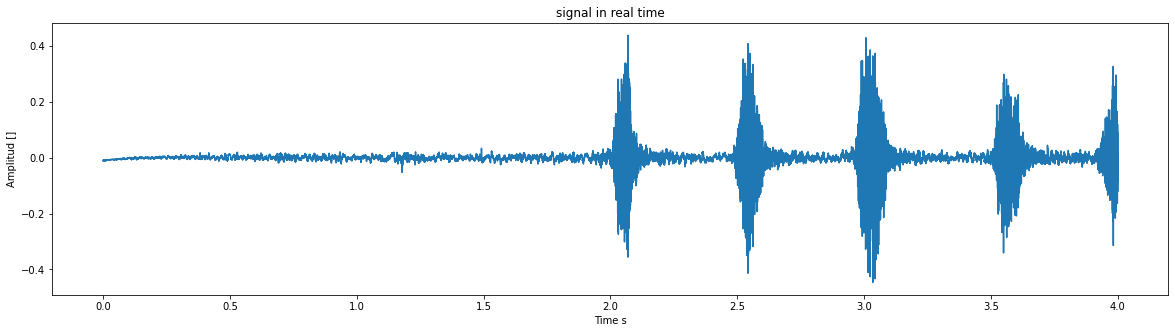

Dimención de la STFT:  (513, 344)
Clase:  001 - Dog bark
Windowing Time:  0.02327272727272727 s
tiempo de ejecución STFT: 7.742643 uS


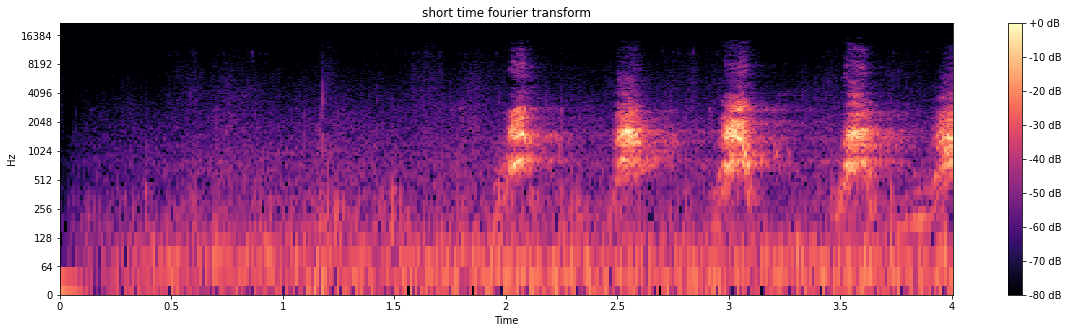

In [3]:
# ANALIZANDO UNA MUESTRA 
example = 2
#sound_duration = 4 # se desea que todas las muestren duren 4 segundos y se las fuerza a serlo
max_leng = int(sound_duration*samplerate)
step = sound_duration/max_leng
print("Duración: ", sound_duration,"s")
print("SampleTime: {:6f}s ".format(step))
# Se completa con ceros hasta alcanzar la longitud igual para todas las muestras
data_sound = audio_data[example][:max_leng] if len(audio_data[example]) > max_leng else np.pad(audio_data[example], (0,max_leng-len(audio_data[example])), constant_values = (0,0))
# Visualizando Sonido en el Tiempo vs Amplitud
save_path= 'tiempoVSamp.jpg'
print("Cantidad de muestras: ",len(data_sound))
plt.plot([step*i for i in range(len(data_sound))],data_sound)
plt.xlabel('Time s')
plt.ylabel('Amplitud []')
plt.title('signal in real time')
pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
plt.show()
#pylab.close()

# Analizando Sonido ZTiempo vs Coef STFT
time_init = time.time()
rcParams['figure.figsize'] = 20, 5
n_fft = 1024 # n_fft/2+1 como la cantidad de bandas a descomponer en el espectro de frecuencia
win_length=1024 # Ventaneo de la STFT
hop_length=int(win_length/2) # Desplazamiento de la ventana de transformación
freq = librosa.amplitude_to_db(np.abs(librosa.stft(data_sound,n_fft=n_fft, win_length=win_length ,hop_length=hop_length)), ref=np.max) #Se obtiene la potencia de la transformada 
print("Dimención de la STFT: ", freq.shape)
print("Clase: ",classes[labels[example]])
print("Windowing Time: ", win_length*1/samplerate,"s")
time_final = time.time()
data = (time_final- time_init )/1000
print("tiempo de ejecución STFT: {:2f} uS".format(data*10**6))
save_path2 = 'SFTF_'+save_path
#plt.axis('off') # no axis
librosa.display.specshow(freq,hop_length=hop_length,x_axis='time', y_axis='log',sr=44000, )
plt.colorbar(format='%+2.0f dB')
plt.title('short time fourier transform')
pylab.savefig(save_path2, bbox_inches=None, pad_inches=0)
#pylab.close()
ipd.Audio(data_sound, rate=samplerate) # load a NumPy array

In [3]:
# Aplicando STFT a todas las muestras de sonido
n_fft = 1024 # n_fft/2+1 como la cantidad de bandas a descomponer en el espectro de frecuencia
win_length=1024 # Ventaneo de la STFT
hop_length=int(win_length/2) # Desplazamiento de la ventana de transformación

audio_data,labels,stft_shape = STFT_sound_DB(audio_data_orig,labels_orig,n_fft,win_length,hop_length)

print(stft_shape)
print(audio_data.shape)

# Normalizando datos
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(audio_data,y = audio_data)
normalized_stft = scaler.transform(audio_data)
print(np.amax(audio_data))
print(np.amax(normalized_stft))
audio_data =None

# Dividiendo lasmuestras de forma homogenea
#from skmultilearn.model_selection import iterative_train_test_split
X_train, X_test, y_train, y_test = train_test_split(normalized_stft,labels, test_size=0.20,random_state =50,stratify= labels)
normalized_stft = None
print("Split ready")

400it [00:02, 156.10it/s]


(344, 513)
(400, 176472)
3.8146973e-06
1.0001221
Split ready


[LibSVM]SVM: acc:0.625


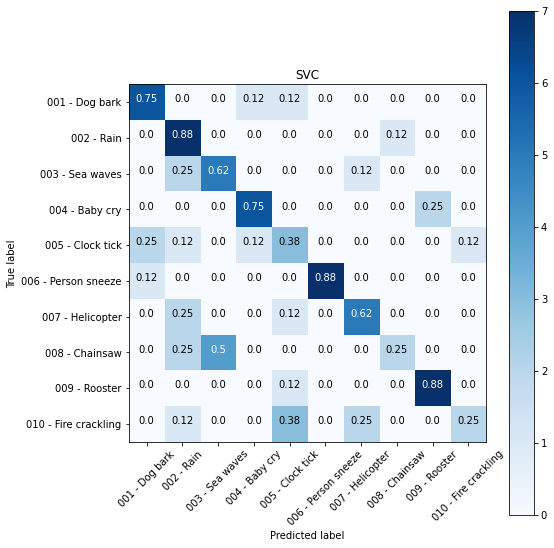

In [35]:
#Modelo con SVC
clf = svm.SVC(verbose= True,random_state=5,C=10, kernel='linear', gamma='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("SVM: acc:"+ str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix(y_true=y_test, y_pred=clf.predict(X_test), class_names=classes,title="SVC",normalize=True)

Cantidad de caracteristicas 176472
[LibSVM]SVM+PCA: acc:0.6125


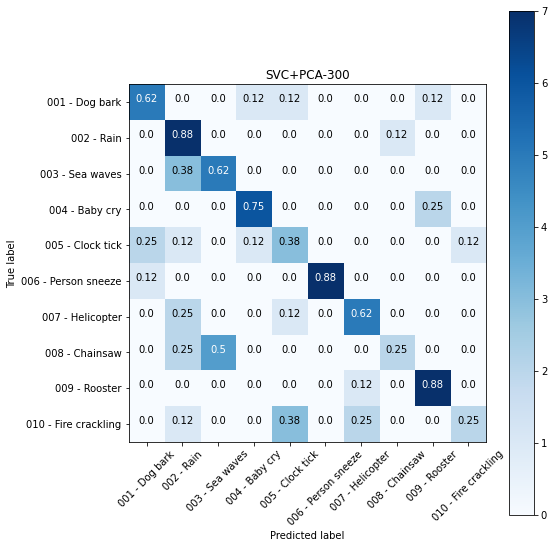

In [38]:
# Modelo con PCA y SVC
print("Cantidad de caracteristicas", len(X_train[0]))
n_components=300
pca = PCA(n_components=n_components)
pca.fit(X_train) ## justa para todo el espectro de datos
X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)
clf_PCA = svm.SVC(verbose= True,random_state=5,C=10, kernel='linear', gamma='auto', probability=True )
clf_PCA.fit(X_train_PCA, y_train)
y_pred = clf_PCA.predict(X_test_PCA)
print("SVM+PCA: acc:"+ str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix(y_true=y_test, y_pred=y_pred, class_names=classes,title="SVC+PCA-"+str(n_components),normalize=True)

Cantidad de caracteristicas 176472
[LibSVM]SVM+NCA: acc:0.625


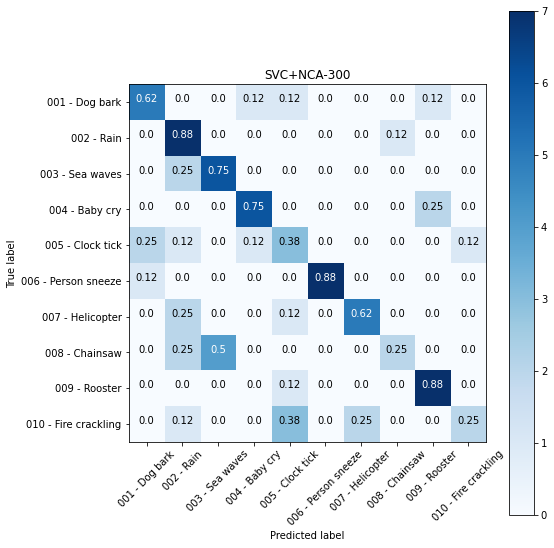

In [9]:
# Modelo con NCA y SVC
print("Cantidad de caracteristicas", len(X_train[0]))
n_components=300
nca = NCA(n_components=n_components,random_state=2)
nca.fit(X_train,y_train) ## justa para todo el espectro de datos
X_train_NCA = nca.transform(X_train)
X_test_NCA = nca.transform(X_test)
clf_NCA = svm.SVC(verbose= True,random_state=5,C=10, kernel='linear', gamma='scale', probability=True )
clf_NCA.fit(X_train_NCA, y_train)
y_pred = clf_NCA.predict(X_test_NCA)
print("SVM+NCA: acc:"+ str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix(y_true=y_test, y_pred=y_pred, class_names=classes,title="SVC+NCA-"+str(n_components),normalize=True)

Cantidad de caracteristicas 176472
KNC+NCA: acc:0.45


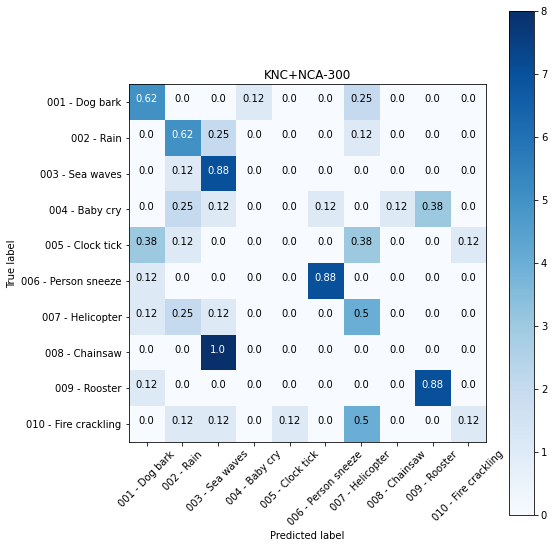

In [15]:
# Modelo con NCA y KNC
print("Cantidad de caracteristicas", len(X_train[0]))
clf_KNC = KNC(n_neighbors=10,n_jobs=-1,algorithm='brute',p=2 )
clf_KNC.fit(X_train_NCA, y_train)
y_pred = clf_KNC.predict(X_test_NCA)
print("KNC+NCA: acc:"+ str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix(y_true=y_test, y_pred=y_pred, class_names=classes,title="KNC+NCA-"+str(n_components),normalize=True)

Cantidad de caracteristicas 176472
KNC+PCA: acc:0.45


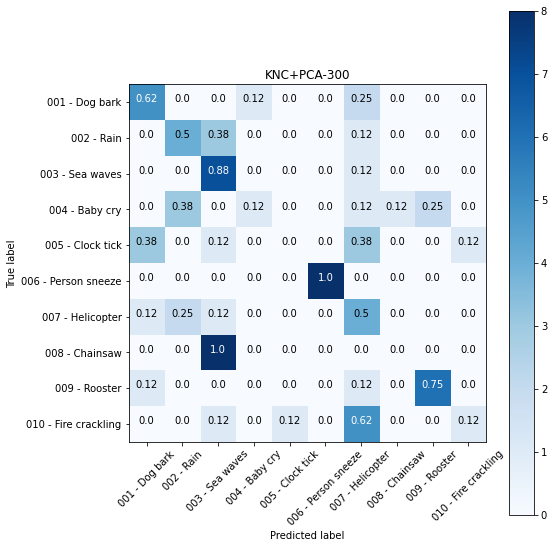

In [23]:
# Modelo con PCA+KNC
print("Cantidad de caracteristicas", len(X_train[0]))
n_components=300
pca = PCA(n_components=n_components)
pca.fit(X_train) ## justa para todo el espectro de datos
X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)
clf_KNC = KNC(n_neighbors=10,n_jobs=-1,algorithm='auto',p=2,weights='distance' )
clf_KNC.fit(X_train_PCA, y_train)
y_pred = clf_KNC.predict(X_test_PCA)
print("KNC+PCA: acc:"+ str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix(y_true=y_test, y_pred=y_pred, class_names=classes,title="KNC+PCA-"+str(n_components),normalize=True)

XGB+PCA: acc:0.6375


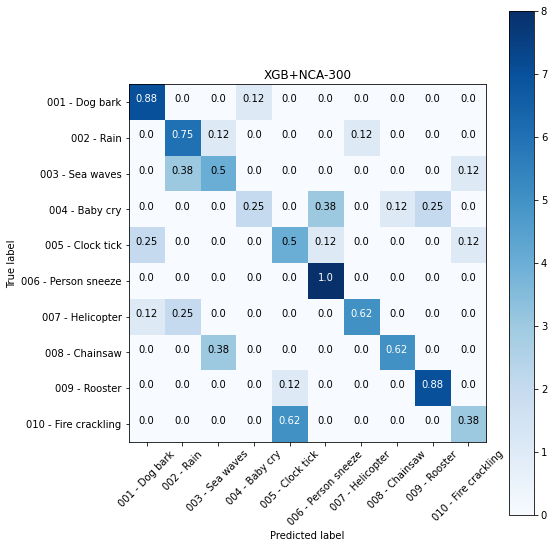

In [25]:
# Modelo clasificador con XGB & PCA
n_components=300
nca = NCA(n_components=n_components,random_state=2)
nca.fit(X_train,y_train) ## justa para todo el espectro de datos
X_train_NCA = nca.transform(X_train)
X_test_NCA = nca.transform(X_test)
xgb_model = XGBClassifier(learning_rate=0.01,
                    n_estimators=1200,
                    max_depth=100,
                    min_child_weight=.05,
                    gamma=0,
                    subsample=.5,
                    colsample_bytree=0.5,
                    objective='multi:softmax',
                    num_class=10,
                    num_parallel_tree = 18,
                    seed=27,verbosity= 1,n_jobs=8 )
xgb_model.fit(X_train_NCA, y_train)
#xgb_model.save_model('models/xgbmodel')
y_pred = xgb_model.predict(X_test_NCA)
print("XGB+PCA: acc:"+ str(accuracy_score(y_test, y_pred)))
plot_confusion_matrix(y_true=y_test, y_pred=y_pred, class_names=classes,title="XGB+NCA-"+str(n_components),normalize=True)

# CRNN 
## Entrenamiento mediante el uso de un generador

In [4]:
# Dividiendo lasmuestras de forma homogenea
# audio_data, labels,classes
X_trainG, X_testG, y_trainG, y_testG = train_test_split(audio_data_orig,labels_orig, test_size=0.20,random_state =50,stratify= labels_orig)
#audio_data_orig = None
gc.collect()
print("Split ready")
n_fft = 1024 # n_fft/2+1 como la cantidad de bandas a descomponer en el espectro de frecuencia
win_length=1024 # Ventaneo de la STFT
hop_length=int(win_length/2) # Desplazamiento de la ventana de transformación 

train_gen = DataSoundGenerator(Xsound=X_trainG, 
                              Yclass=np.array(y_trainG),
                              batch_size=12, 
                              childrens=5, n_fft = n_fft, win_length=win_length, hop_length=hop_length, 
                              num_classes=10,
                              random_state=5)

val_gen = DataSoundGenerator(Xsound=X_testG, 
                              Yclass=np.array(y_testG),
                              batch_size=8, 
                              childrens=3, n_fft = n_fft, win_length=win_length, hop_length=hop_length, 
                              num_classes=10,
                              random_state=5)
input_shape_nn =  train_gen.shape_spectro[0],train_gen.shape_spectro[1],1
#print(traingen.shape_spectro)
print(input_shape_nn)

#print(traingen.__getitem__(0)[0] )
#model2.fit(traingen,epochs=3, workers=8 )

Split ready
Generador de Sonido =====>
Se cuenta con  320 datos originales
Se generarán  1600 datos sintéticos más
Generador de Sonido =====>
Se cuenta con   80 datos originales
Se generarán   240 datos sintéticos más
(344, 513, 1)


## Entrenamiento usando solo las 400 muestras

In [5]:
# Preparando datos para la CNN
X_train_NN= np.reshape(X_train,(X_train.shape[0],stft_shape[0], -1,1))
X_test_NN = np.reshape(X_test,(X_test.shape[0],stft_shape[0], -1,1))
y_train_NN=keras.utils.to_categorical(y_train, num_classes=10, dtype='float32')
y_test_NN =keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')
X_train_NN.shape

(320, 344, 513, 1)

## Cargando el modelo

In [6]:
# Compra para compra de proyecto de IVA
#input_shape_nn = X_train_NN.shape[1:]
reshape_time_len = int(input_shape_nn[0]/4) # entre 4 debido a que hay dos MaxPooling cada uno divide en 2 la dimensión
reshape_feature_len = int(input_shape_nn[1]/4)

model = model_CRNN(input_shape_nn,reshape_time_len,reshape_feature_len)
n_epochs = 0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 344, 513, 8)       208       
_________________________________________________________________
activation (Activation)      (None, 344, 513, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 172, 256, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 172, 256, 16)      3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 172, 256, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 172, 256, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 86, 128, 16)       0

## Entrenamiento de la CRNN

In [17]:
# %% 
# Entrenando modelo con el generador
logdir="logs7" 
epoch_add = 20
tboard_callback = TensorBoard(log_dir=logdir)
model_checkpoint = ModelCheckpoint('models/soundClassCRNNGEN{val_loss:.4f}acc_val{val_accuracy:.4f}_train{accuracy:.4f}.hdf5', monitor='val_loss',verbose=1, save_best_only=True) 
history = model.fit(train_gen,
                    #steps_per_epoch = 8,   #cantidad de veces que se calculará el gradiente |DATOStotale = steps_per_epoch * batch_size
                    #batch_size=16,          #cantidad de muestras para calcular el gradiente
                    epochs=n_epochs+epoch_add,
                    initial_epoch = n_epochs,
                    callbacks=[tboard_callback,model_checkpoint],
                    validation_data = val_gen,
                   workers=8)
n_epochs=n_epochs+epoch_add

InternalError: GPU sync failed

Pesos cargados
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 344, 513, 8)       208       
_________________________________________________________________
activation_6 (Activation)    (None, 344, 513, 8)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 172, 256, 8)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 172, 256, 16)      3200      
_________________________________________________________________
batch_normalization_6 (Batch (None, 172, 256, 16)      64        
_________________________________________________________________
activation_7 (Activation)    (None, 172, 256, 16)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 86,

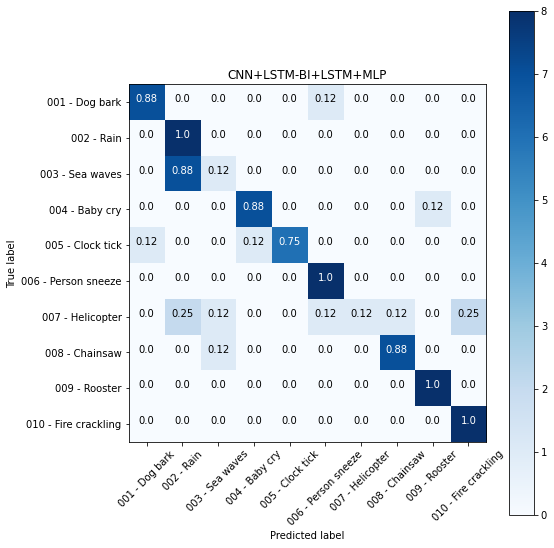

In [13]:
model = model_CRNN(input_shape_nn,reshape_time_len,reshape_feature_len,saved_file='models/soundClassCRNNGEN0.5194acc_val0.8958_train0.7513.hdf5' )
y_pred=model.predict(X_test_NN)
print("CNN+LSTM-BI+LSTM+MLP: acc:"+ str(accuracy_score([y_i.argmax() for y_i in y_test_NN], [y_i.argmax() for y_i in y_pred])))
plot_confusion_matrix(y_true=y_test_NN, y_pred=y_pred, class_names=classes,title="CNN+LSTM-BI+LSTM+MLP",normalize=True,onehot=True )

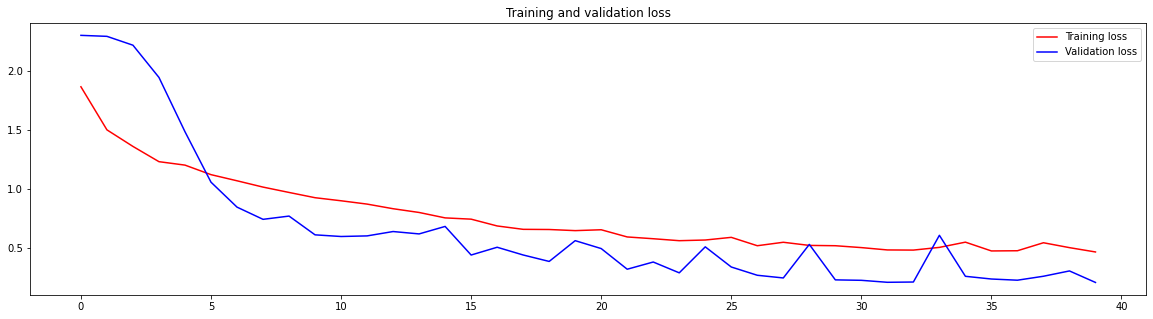

<Figure size 1440x360 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0) 
plt.figure()
plt.show()